# Trabalho Prático 1 - ALG2
**Aluno:** César de Paula Morais - 2021031521

**Aluno:** Matheus Grandinetti Barbosa Lima - 2021067496

**Aluno:** Pedro Henrique Fernandes Baptista - 2021031610

## Introdução

<p style="text-align: justify;">Este notebook lida com a problemática da classificação de pontos inseridos em modelo previamente treinado. O treinamento acontece por meio da criação de envoltórias convexas, bem como a verificação da separabilidade linear entre duas envoltórias e a identificação de um ponto médio entre essas, de forma a obter um modelo de classificação que pode ser usado em datasets diversos. Para melhor explicação dos algoritmos e dos passos necessários para a criação dos modelos, o trabalho será divido em 5 principais partes:</p>

*   Primitivas
*   Envoltória convexa
*   Separabilidade linear
*   Ponto médio entre envoltórias
*   Criação e análise dos modelos







## Imports ##

In [1]:
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
from sklearn import datasets, metrics
from sklearn.decomposition import PCA
import numpy as np

## Primitivas

As seguintes classes básicas foram criadas como forma de abstrair conceitos geométricos importantes para o experimento.

**Ponto:**

In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    # Id means to which group the point belongs
    def set_id(self, id):
        self.id = id

**Segmento:**

In [3]:
class Segment:
    def __init__(self, smaller: Point, greater: Point):
        self.smaller = smaller
        self.greater = greater

Além disso, foram utilizadas algumas funções auxiliares, agrupados na classe *Tools*:

In [4]:
class Tools:
    @classmethod
    def do_segments_intercept(cls, s1: Segment, s2: Segment):
        if s1.smaller == s2.smaller or s1.smaller == s1.greater or s1.smaller == s2.greater or s1.smaller == s2.greater:
            return True

        o1 = cls.find_orientation(s1.smaller, s1.greater, s2.smaller)
        o2 = cls.find_orientation(s1.smaller, s1.greater, s2.greater)
        o3 = cls.find_orientation(s2.smaller, s2.greater, s1.smaller)
        o4 = cls.find_orientation(s2.smaller, s2.greater, s1.greater)

        # General case
        if o1 != o2 and o3 != o4:
            return True

        # Special cases (colinear or one segment's endpoint on the other segment)
        if (
            o1 == 0 and cls.on_segment(s1.smaller, s2.smaller, s1.greater)
            or o2 == 0 and cls.on_segment(s1.smaller, s2.greater, s1.greater)
            or o3 == 0 and cls.on_segment(s2.smaller, s1.smaller, s2.greater)
            or o4 == 0 and cls.on_segment(s2.smaller, s1.greater, s2.greater)
        ):
            return True
        return False

    @classmethod
    # Check if point q lies on line segment pr
    def on_segment(cls, p, q, r):
        return (
            (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x))
            and (q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))
        )

    def find_orientation(p1: Point, p2: Point, p3: Point):
        cross_product = (p2.y - p1.y) * (p3.x - p2.x) - (p2.x - p1.x) * (p3.y - p2.y)

        if cross_product == 0:
            return 0
        elif cross_product > 0:
            return 1
        else:
            return -1

    def point_to_list(set: list[Point]):
      x_list = [point.x for point in set]
      y_list = [point.y for point in set]

      return (x_list, y_list)

    def get_point_distance(p1: Point, p2: Point):
        return abs(pow((pow((p1.x - p2.x), 2) + pow((p1.y - p2.y), 2)), 0.5))
    
    @classmethod
    def points_to_np_array(cls, points :list[Point]):
        point_arrays = []

        for p in points:
            np_p = np.array([p.x, p.y])
            point_arrays.append(np_p)

        if point_arrays:  # Check if there are any point arrays
            array = np.vstack(point_arrays)
        else:
            array = np.array([])

        return array
    
    @classmethod
    def pointsort(cls, array):
        cls._point_sort(array, 0, len(array)-1)
        
    @classmethod
    def _point_sort(cls, array, low, high):
        if low < high:
            pi = cls._partition(array, low, high)
            cls._point_sort(array, low, pi-1)
            cls._point_sort(array, pi+1, high)
    
    @classmethod
    def _partition(cls, array, low, high):
        # Pivot is last element
        pivot = array[high]
        p = low-1
        
        for j in range(low,high):
            if array[j].x < pivot.x or (array[j].x == pivot.x and array[j].y < pivot.y):
                p = p + 1
                (array[p], array[j]) = (array[j], array[p])
                
        (array[p + 1], array[high]) = (array[high], array[p + 1])
        
        return p + 1
    
    def point_to_list(set: [Point]):
      x_list = [point.x for point in set]
      y_list = [point.y for point in set]

      return (x_list, y_list)
    
    def point_inside_hull(point: Point, point_list: list[Point]):
        crossings = 0

        point_list.append(point_list[0])

        for iter in range(0, len(point_list)-1):
            slope = (point_list[iter+1].y - point_list[iter].y) / (point_list[iter+1].x - point_list[iter].x)
            cond1 = (point_list[iter].x <= point.x) and (point.x < point_list[iter+1].x)
            cond2 = (point_list[iter+1].x <= point.x) and (point.x < point_list[iter].x)
            above = (point.y < slope * (point.x - point_list[iter].x) + point_list[iter].y)
            
            if((cond1 or cond2) and above): crossings +=1
        return (crossings % 2 != 0)

## Envoltória Convexa

<p style="text-align: justify;">Para resolver a problemática da envoltória convexa, utilizamos o algoritmo de Jarvis, conhecido também como Gift Wrap. Funções auxiliares foram criadas com o objetivo de facilitar a manutenção e visualização dos resultados obtidos dentro da classe ConvexHull.</p>

In [5]:
class ConvexHull:
    def __init__(self, point_set):
        self.point_set = point_set
        self.hull = []
        self.tools = Tools

    def find_point_index(self, p):
        index = 0

        for point in self.point_set:
            if p.x == point.x and p.y == point.y:
                return index
            index += 1

    def find_ancor(self):
        ancor = self.point_set[0]

        for point in self.point_set:
            if point.x < ancor.x:
                ancor = point

        return ancor

    def find_next_ancor(self, p, q):
        for point in self.point_set:
            if self.tools.find_orientation(p,q,point) == 1:
                q = point

        return q

    def find_convex_hull(self):
        set_size = len(self.point_set)

        ancor = self.find_ancor()
        self.hull.append(ancor)
        next = self.point_set[(self.find_point_index(ancor)+1)%set_size]

        current = self.find_next_ancor(ancor, next)

        while True:
            self.hull.append(current)
            next = self.point_set[(self.find_point_index(current)+1)%set_size]
            current = self.find_next_ancor(current, next)

            if current.x == self.hull[0].x and current.y == self.hull[0].y:
                break

        return self.hull

<p style="text-align: justify;">Para verificar a corretude do código, vamos plotar alguns pontos básicos, verificando se a envoltória gerada pelo algoritmo possui o comportamento esperado.</p>

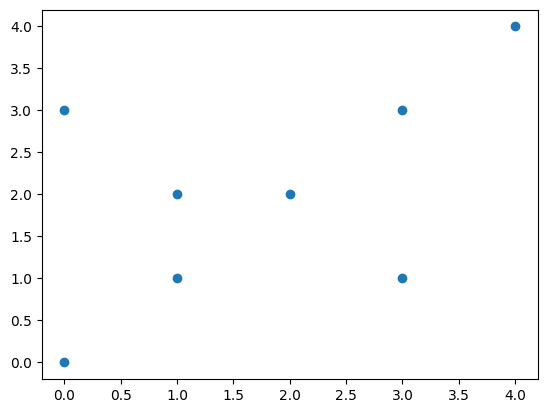

In [6]:
point_set = []

point_set.append(Point(0,3))
point_set.append(Point(0,0))
point_set.append(Point(1,1))
point_set.append(Point(2,2))
point_set.append(Point(3,3))
point_set.append(Point(4,4))
point_set.append(Point(3,1))
point_set.append(Point(1,2))

array_point_set = Tools.point_to_list(set=point_set)

plt.scatter(x=array_point_set[0],y=array_point_set[1])
plt.show()

Utilizando a função *find_convex_hull*, obtemos os pontos que fazem parte da envoltória, temos portanto:

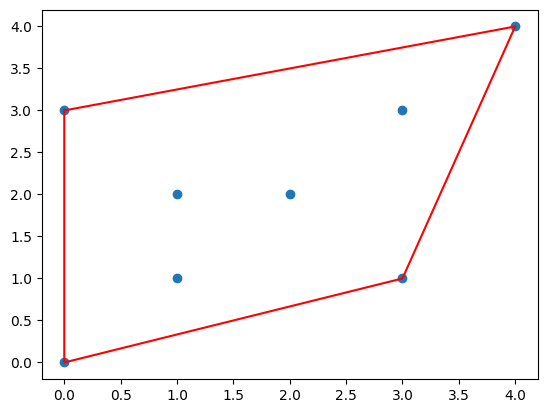

In [7]:
hull = ConvexHull(point_set)
hull_points = hull.find_convex_hull()
hull_points_array = Tools.point_to_list(set=hull_points)
hull_points_array[0].append(hull_points[0].x)
hull_points_array[1].append(hull_points[0].y)

plt.plot(hull_points_array[0],hull_points_array[1], color="red")
plt.scatter(x=array_point_set[0],y=array_point_set[1])
plt.show()

<p style="text-align: justify;">Vamos analisar agora um exemplo gerado aleatoriamente, representando uma envoltória de 50 pontos. É possivel gerar novos exemplos executando a célula abaixo novamente.</p>

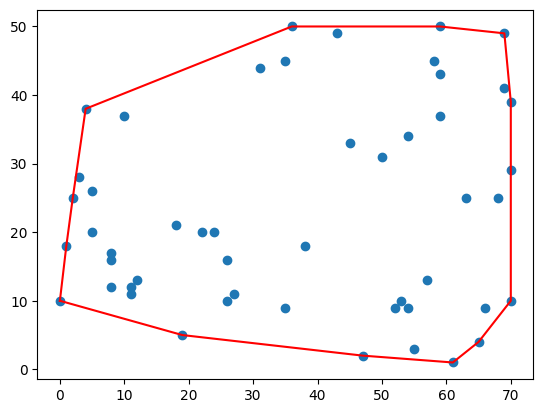

In [8]:
random_point_set = []
for x in range(0,50):
  random_point_set.append(Point(randint(0,70),randint(0,50)))

new_array_point_set = Tools.point_to_list(set=random_point_set)

plt.scatter(x=new_array_point_set[0],y=new_array_point_set[1])

new_hull = ConvexHull(random_point_set)
new_hull_points = new_hull.find_convex_hull()
new_hull_points_array = Tools.point_to_list(set=new_hull_points)
new_hull_points_array[0].append(new_hull_points[0].x)
new_hull_points_array[1].append(new_hull_points[0].y)

plt.plot(new_hull_points_array[0],new_hull_points_array[1], color="red")
plt.show()


## Separabilidade Linear

<p style="text-align: justify;">Agora, precisamos ter uma forma de testar se duas envoltórias se interceptam. Isso  é necessário, pois o algoritmo só funcionará caso as envoltórias não possuam interseção uma com a outra.</p>

In [9]:
class HullInterception:
    @classmethod
    def do_hulls_intercept(cls, hull_1: list[Point], hull_2: list[Point]):
        for p1, p2 in zip(hull_1, hull_1[1:]):
            smaller_1 = p1 if p1.x < p2.x else p2
            greater_1 = p1 if smaller_1 == p2 else p2

            for p3, p4 in zip(hull_2, hull_2[1:]):
                smaller_2 = p3 if p3.x < p4.x else p4
                greater_2 = p3 if smaller_2 == p4 else p4
                if Tools.do_segments_intercept(Segment(smaller_1, greater_1), Segment(smaller_2, greater_2)):
                    return True
            # Check last segment from 2nd hull
            if Tools.do_segments_intercept(Segment(smaller_1, greater_1), Segment(hull_2[0], hull_2[-1])):
                return True

        # Check last segment from 1st hull
        last_segment = Segment(hull_1[0], hull_1[-1])
        for p3, p4 in zip(hull_2, hull_2[1:]):
            smaller = p3 if p3.x < p4.x else p4
            greater = p3 if smaller == p4 else p4
            if Tools.do_segments_intercept(last_segment, Segment(smaller, greater)):
                return True

        # Check last segment from both
        if Tools.do_segments_intercept(last_segment, Segment(hull_2[0], hull_2[-1])):
            return True

        # Checking the possibility of a hull being inside the other
        for point in hull_1:
            if Tools.point_inside_hull(point, hull_2) == True: return True
        for point in hull_2:
            if Tools.point_inside_hull(point, hull_1) == True: return True

        return False        

## Ponto médio entre envoltórias

<p style="text-align: justify;">Com as envoltórias disponíveis e a certeza de que não há interseção entre elas, podemos partir para a criação do nosso modelo de classificação, utilizando um ponto médio entre os poligonos obtidos.<p>

In [10]:
INF = 0x3f3f3f3f

def find_closest_points(hull1: ConvexHull, hull2: ConvexHull):
    dist_min = INF
    closest = tuple((Point(0,0), Point(0,0)))
    for point1 in hull1.hull:
        for point2 in hull2.hull:
            dist_temp = Tools.get_point_distance(point1, point2)
            if dist_temp < dist_min:
                dist_min = dist_temp
                closest = tuple((point1, point2))
    return closest

def assign_hull(point: Point, hull1: ConvexHull, hull2: ConvexHull):
    point_hull1, point_hull2 = find_closest_points(hull1, hull2)

    if Tools.get_point_distance(point, point_hull1) < Tools.get_point_distance(point, point_hull2):
        return 1
    else:
        return 2

def get_x_range(hull1: ConvexHull, hull2: ConvexHull):
    min_x = INF
    max_x = -INF
    for point1 in hull1.hull:
      if point1.x < min_x:
        min_x = point1.x
      if point1.x > max_x:
        max_x = point1.x
    for point2 in hull2.hull:
      if point2.x < min_x:
        min_x = point2.x
      if point2.x > max_x:
        max_x = point2.x
    return min_x, max_x

def separating_line_formula(x, hull1: ConvexHull, hull2: ConvexHull):
    point_hull1, point_hull2 = find_closest_points(hull1, hull2)

    linear_coefficient = (point_hull1.y - point_hull2.y) / (point_hull1.x - point_hull2.x)

    intercept = (point_hull1.y + point_hull2.y)/2 - ((-1/linear_coefficient) * (point_hull1.x + point_hull2.x)/2)

    return (-1 / linear_coefficient * x) + intercept

def plot_separating_line(hull1: ConvexHull, hull2: ConvexHull):
    point_hull1, point_hull2 = find_closest_points(hull1, hull2)

    half_point = Point((point_hull1.x + point_hull2.x)/2, (point_hull1.y + point_hull2.y)/2)

    x = [point_hull1.x, point_hull2.x]
    y = [separating_line_formula(point_hull1.x, hull1, hull2), separating_line_formula(point_hull2.x, hull1, hull2)]

    plt.plot(x, y, color="green", linestyle='dashed')

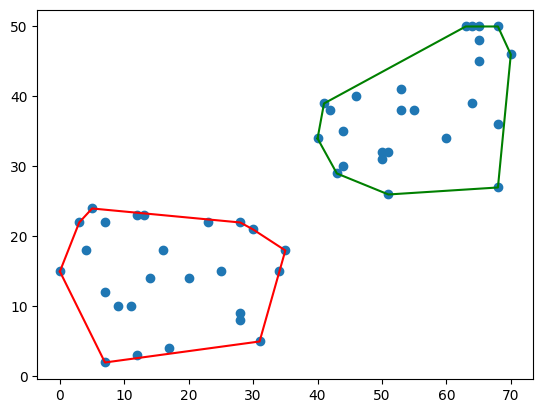

In [11]:
full_point_set = []

random_point_set1 = []
for x in range(0,25):
  point_temp = Point(randint(0,35),randint(0,25))
  random_point_set1.append(point_temp)
  full_point_set.append(point_temp)

new_array_point_set = Tools.point_to_list(set=random_point_set1)

random_point_set2 = []
for x in range(0,25):
  point_temp = Point(randint(35,70),randint(26,50))
  random_point_set2.append(point_temp)
  full_point_set.append(point_temp)

new_array_point_set_full = Tools.point_to_list(set=full_point_set)
new_array_point_set1 = Tools.point_to_list(set=random_point_set1)
new_array_point_set2 = Tools.point_to_list(set=random_point_set2)

plt.scatter(x=new_array_point_set_full[0],y=new_array_point_set_full[1])

new_hull1 = ConvexHull(random_point_set1)
new_hull_points1 = new_hull1.find_convex_hull()
new_hull_points_array1 = Tools.point_to_list(set=new_hull_points1)
new_hull_points_array1[0].append(new_hull_points1[0].x)
new_hull_points_array1[1].append(new_hull_points1[0].y)

new_hull2 = ConvexHull(random_point_set2)
new_hull_points2 = new_hull2.find_convex_hull()
new_hull_points_array2 = Tools.point_to_list(set=new_hull_points2)
new_hull_points_array2[0].append(new_hull_points2[0].x)
new_hull_points_array2[1].append(new_hull_points2[0].y)

plot_separating_line(new_hull1, new_hull2)
plt.plot(new_hull_points_array1[0],new_hull_points_array1[1], color="red")
plt.plot(new_hull_points_array2[0],new_hull_points_array2[1], color="green")
plt.show()


## Criação e análise de modelos

### Classes de tratamento
Antes de começar a análise de datasets, vamos criar algumas classes e funções que ajudam visualização dos dados e dos resultados obtidos.

In [ ]:
class DataTraining:
    # Works with numpy arrays or Point arrays
    @classmethod
    def separate_dataset(cls, array_1, array_2):
        point_set_1 = []
        point_set_2 = []
        
        for point in array_1:
            if type(point) != Point:
                point = Point(point[0],point[1])
            point.set_id(1)
            point_set_1.append(point)
        for point in array_2:
            if type(point) != Point:
                point = Point(point[0],point[1])
            point.set_id(2)
            point_set_2.append(point)
            
        order_set = point_set_1 + point_set_2
        Tools.pointsort(order_set)
        
        # Separating 70% and 30%        
        ## Goes through the list until it finds first point of different type
        first_type = order_set[0].id
        element_index = -1
        for point in order_set:
            if point.id != first_type:
                element_index = order_set.index(point)
                break
        
        ## Now we've found "separating element", let's remove 30% from list
        test_amount = int(len(order_set) * 0.3)
        test_list = []
        for i in range(1, test_amount):
            test_list.append(order_set.pop(element_index))
            element_index += 1

        ## Separate into model sets
        model_set_1 = []
        model_set_2 = []
        for p in order_set:
            if p.id == 1:
                model_set_1.append(p)
            else:
                model_set_2.append(p)
        
        # order_set gets 70% of original points
        return model_set_1, model_set_2, test_list    
    
    @classmethod
    def test_model(cls, hull_1: ConvexHull, hull_2: ConvexHull, test_points: list[Point]):
        # Talvez haja problema em verificar qual hull é "1" e qual é "2". Do meu lado, hull_1 é aquele que tem ponto de menor x
        true_values = [i.id for i in test_points]
        predicted_values = []
        
        # Checking results
        for point in test_points:
            model_result = ClasseDoPedrao.assign_hull(point, hull_1, hull_2)
            predicted_values.append(model_result)
                    
        # Calculating metrics with scikit learn -> check "average" param
        ## Precision = true_positives/positives
        precision = metrics.precision_score(true_values, predicted_values, average='micro')
        ## Recall (revocação) = true_positives/(true positives + false negatives)
        recall = metrics.recall_score(true_values, predicted_values, average='micro')
        ## f1-score -> uses precision and recall to eval quality of model in general
        f1_score = (2*precision*recall) / (precision+recall)
        
        return precision, recall, f1_score

In [ ]:
class DataPlot:
    def __init__(self):
        ...
    
    def hull_plot(point_set, color):
        set_hull = ConvexHull(point_set)
        set_hull_points = set_hull.find_convex_hull()
        set_hull_points_arr = Tools.point_to_list(set=set_hull_points)
        set_hull_points_arr[0].append(set_hull_points[0].x)
        set_hull_points_arr[1].append(set_hull_points[0].y)
        
        plt.plot(set_hull_points_arr[0], set_hull_points_arr[1], color=color)
        
        return set_hull
    
    def scatter_plot(point_set):
        ...
    

## Pipeline de Modelos ##

In [ ]:
class GenerateModel:
    @classmethod
    def plot_model(self, class_set, point_color: str, test: bool, **kwargs):
        plt.scatter(class_set[:,0], class_set[:,1], color=point_color)

        if (not test):
            class_hull = kwargs.get("class_hull", ConvexHull)
            hull_color = kwargs.get("hull_color", str)
            class_hull_points_arr = Tools.point_to_list(class_hull.find_convex_hull())
            class_hull_points_arr[0].append(class_hull.find_convex_hull()[0].x)
            class_hull_points_arr[1].append(class_hull.find_convex_hull()[0].y)
            plt.plot(class_hull_points_arr[0], class_hull_points_arr[1], color=hull_color)


    @classmethod
    def generate_by_csv(self, csv_file: str, class_column: str, class1_name: str, class2_name: str):
        dataset = pd.read_csv(csv_file)
        dataset_classes_column = dataset[class_column]
        dataset.drop(columns=class_column, inplace=True)
        
        reduced_dataset = PCA(n_components=2).fit_transform(dataset)
        
        class_A = []
        class_B = []

        index = 0
        for x in dataset_classes_column:
            if x == class1_name:
                class_A.append(reduced_dataset[index])
            elif x == class2_name:
                class_B.append(reduced_dataset[index])
            index += 1

        class_A = np.array(class_A)
        class_B = np.array(class_B)
        
        class_A_point_set = []
        class_B_point_set = []

        for point in class_A:
            class_A_point_set.append(Point(point[0], point[1]))
        for point in class_B:
            class_B_point_set.append(Point(point[0], point[1]))

        class_A_hull = ConvexHull(class_A_point_set)
        class_B_hull = ConvexHull(class_B_point_set)

        # Checking interception before DataTraining
        pre_interception = (HullInterception.do_hulls_intercept(class_A_hull.find_convex_hull(), class_B_hull.find_convex_hull()))
        if (not pre_interception):
            print("The convex hulls do not intercept")

        class_A_point_set, class_B_point_set, test_point_set = DataTraining.separate_dataset(class_A, class_B)

        testing_class = []
        for point in test_point_set:
            testing_class.append([point.x, point.y])

        testing_class = np.array(testing_class)

        # Checking interception after DataTraining
        post_interception = (HullInterception.do_hulls_intercept(class_A_hull.find_convex_hull(), class_B_hull.find_convex_hull()))

        print(pre_interception, post_interception)

        if (pre_interception and not post_interception): print("The convex hulls intercept, but we may use 30 percent of points as test data")
        elif (pre_interception and post_interception):
            print("The convex hulls intercept too strongly to apply a model")
            return        

        # Testing model
        for point_temp in test_point_set:
            print(assign_hull(point_temp, class_A_hull, class_B_hull))
        
        GenerateModel.plot_model(class_B, "royalblue", test=False, class_hull=class_B_hull, hull_color="blue")
        GenerateModel.plot_model(testing_class, "purple", test=True)
        GenerateModel.plot_model(class_A, "orangered", test=False, class_hull=class_A_hull, hull_color="red")

        plt.show()  

/tmp/ipykernel_1281/4157416634.py:107: RuntimeWarning: invalid value encountered in scalar divide
  slope = (point_list[iter+1].y - point_list[iter].y) / (point_list[iter+1].x - point_list[iter].x)


True None
The convex hulls intercept, but we may use 30 percent of points as test data
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
2
1
1
1
2
1
1
1
2
2
1
1
2
2
2
1
2
1
1
1
1
2
1
1
1
1
1
1
1
2
1
1
2
2
2
1
1
2
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

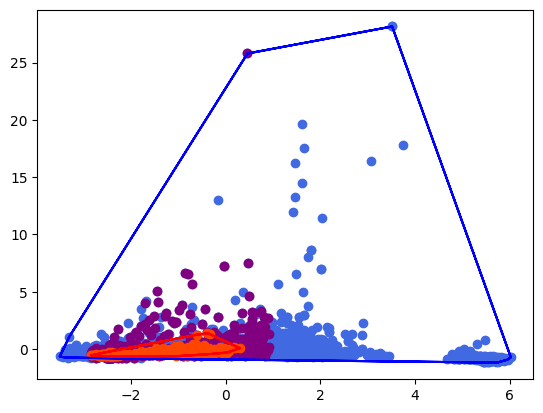

True True
The convex hulls intercept too strongly to apply a model
True True
The convex hulls intercept too strongly to apply a model
True True
The convex hulls intercept too strongly to apply a model
The convex hulls do not intercept


/tmp/ipykernel_1281/4157416634.py:107: RuntimeWarning: invalid value encountered in scalar divide
  slope = (point_list[iter+1].y - point_list[iter].y) / (point_list[iter+1].x - point_list[iter].x)
/tmp/ipykernel_1281/4157416634.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  slope = (point_list[iter+1].y - point_list[iter].y) / (point_list[iter+1].x - point_list[iter].x)


IndexError: pop index out of range

In [ ]:
GenerateModel.generate_by_csv("datasets/segments.csv", "Class", 1)
GenerateModel.generate_by_csv("datasets/banana_prepared.csv", "Class", 1.0)
GenerateModel.generate_by_csv("datasets/mushroom.csv", "Class", 'e')
GenerateModel.generate_by_csv("datasets/shuttle.csv", "Class", 1)
GenerateModel.generate_by_csv("datasets/zoo.csv", "Type", 1)
GenerateModel.generate_by_csv("datasets/wine.csv", "Class", 'Z')
GenerateModel.generate_by_csv("datasets/newthyroid.prepared.csv", "Class", 3)

## Teste 1: Iris ##


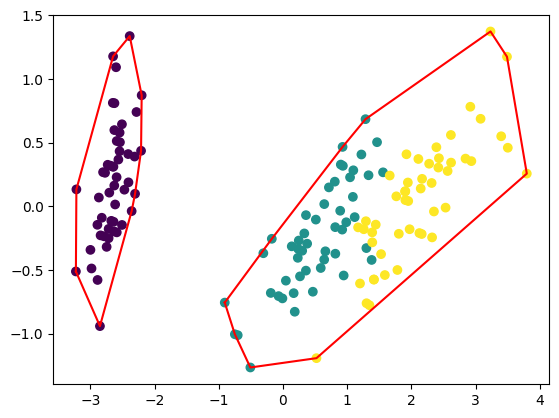

In [ ]:
iris = datasets.load_iris()
# Atenção ao ".data"
iris_reduced_points = PCA(n_components=2).fit_transform(iris.data)

sitosa_set =  []
non_sitosa_set = []

iris_index = 0
for x in iris.target:
    if x == 0:
        sitosa_set.append(Point(iris_reduced_points[iris_index][0], iris_reduced_points[iris_index][1]))
    else:
        non_sitosa_set.append(Point(iris_reduced_points[iris_index][0], iris_reduced_points[iris_index][1]))
    iris_index += 1

DataPlot.hull_plot(sitosa_set, color="red")
DataPlot.hull_plot(non_sitosa_set, color="red")
plt.scatter(x=iris_reduced_points[:, 0], y=iris_reduced_points[:, 1], c=iris.target)

plt.show()

## Teste 2: Câncer de Mama ##

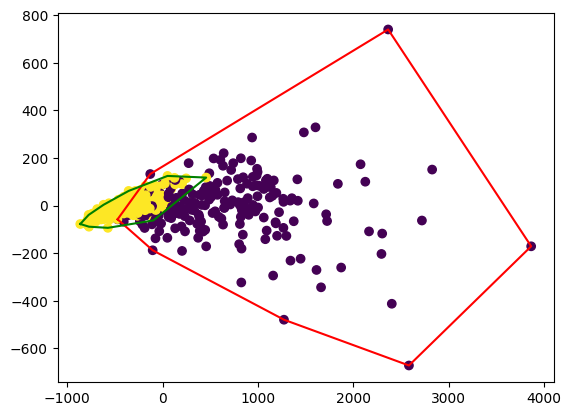

In [ ]:
breast_cancer = datasets.load_breast_cancer()
breast_cancer_reduced_points = PCA(n_components=2).fit_transform(breast_cancer.data)

malignant_set = []
benign_set = []

breast_cancer_index = 0
for x in breast_cancer.target:
    if x == 0:
        malignant_set.append(
            Point(
                breast_cancer_reduced_points[breast_cancer_index][0], 
                breast_cancer_reduced_points[breast_cancer_index][1]
            )
        )
    else:
        benign_set.append(
            Point(
                breast_cancer_reduced_points[breast_cancer_index][0], 
                breast_cancer_reduced_points[breast_cancer_index][1]
            )
        )
    breast_cancer_index+=1

DataPlot.hull_plot(malignant_set, color="red")
DataPlot.hull_plot(benign_set, color="green")

plt.scatter(x=breast_cancer_reduced_points[:, 0], y=breast_cancer_reduced_points[:, 1], c=breast_cancer.target)
plt.show()

## Teste 3: Banana ## 

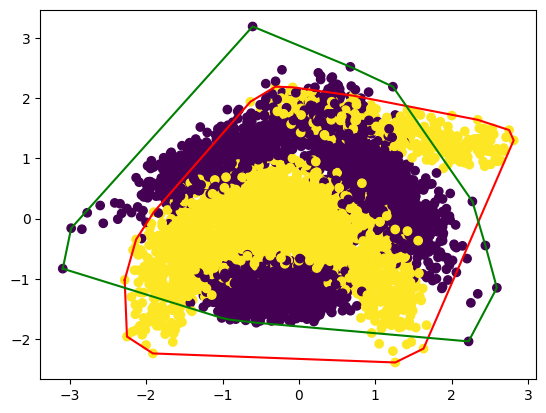

In [ ]:
banana_df = pd.read_csv('datasets/banana_prepared.csv')
banana_df

banana_1_set = []
banana_2_set = []
index = 0
for banana in banana_df['Class']:
    if banana == 1.0:
        banana_1_set.append(Point(banana_df['At1'][index], banana_df['At2'][index]))
    else:
        banana_2_set.append(Point(banana_df['At1'][index], banana_df['At2'][index]))
    index+=1

DataPlot.hull_plot(banana_1_set, color="red")
DataPlot.hull_plot(banana_2_set, color="green")
plt.scatter(x=banana_df['At1'],y=banana_df['At2'], c=banana_df['Class'])
plt.show()

## Teste 4: Segmentos ##

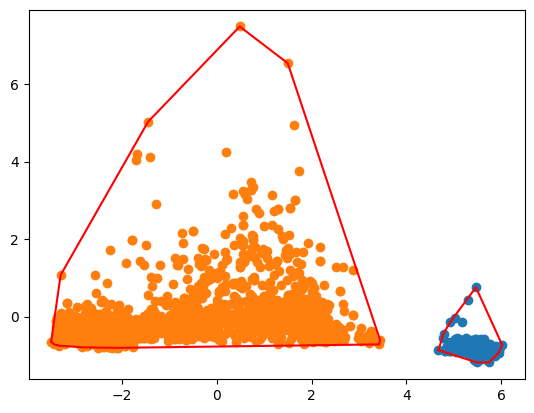

In [ ]:
segments_df = pd.read_csv('datasets/segments.csv')
segments_colors = segments_df['Class']
segments_df.drop(columns='Class', inplace=True)

segments_reduced = PCA(n_components=2).fit_transform(segments_df)

class_2 = []
other_classes = []

index = 0
for color in segments_colors:
    if color == 2:
        class_2.append(segments_reduced[index])
    elif color != 2 and color != 3:
        other_classes.append(segments_reduced[index])
    index+=1

class_2 = np.array(class_2)
other_classes = np.array(other_classes)

class_2_point_set = []
other_point_set = []

for point in class_2:
    class_2_point_set.append(Point(point[0],point[1]))
for point in other_classes:
    other_point_set.append(Point(point[0],point[1]))
    
DataPlot.hull_plot(class_2_point_set, color="red")
DataPlot.hull_plot(other_point_set, color="red")

plt.scatter(class_2[:,0], class_2[:,1])
plt.scatter(other_classes[:,0], other_classes[:,1])

plt.show()

## Teste 5: Cogumelos ##

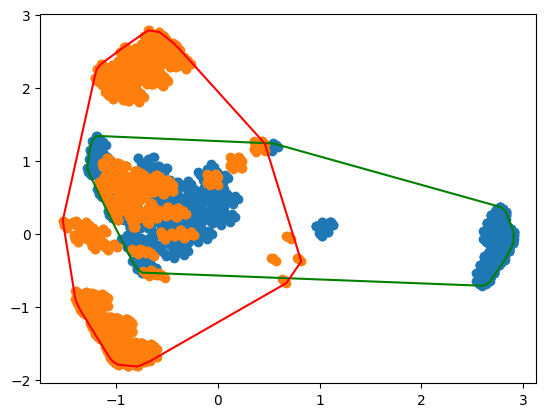

In [ ]:
mushroom_df = pd.read_csv('datasets/mushroom.csv')
mushroom_df.head()

mushroom_type = mushroom_df['Class']
mushroom_df.drop(columns=['Class'], inplace=True)

mushroom_reduced = PCA(n_components=2).fit_transform(mushroom_df)

index=0
p_mushroom = []
e_mushroom = []
for mushroom in mushroom_type:
    if mushroom == 'p':
        p_mushroom.append(mushroom_reduced[index])
    else:
        e_mushroom.append(mushroom_reduced[index])
    index+=1

p_mushroom_arr = np.array(p_mushroom)
e_mushroom_arr = np.array(e_mushroom)

p_mushroom_set = []
e_mushroom_set = []
for mushroom in p_mushroom_arr:
    p_mushroom_set.append(Point(mushroom[0],mushroom[1]))
for mushroom in e_mushroom_arr:
    e_mushroom_set.append(Point(mushroom[0], mushroom[1]))

DataPlot.hull_plot(p_mushroom_set, color="green")
DataPlot.hull_plot(e_mushroom_set, color="red")

plt.scatter(p_mushroom_arr[:,0],p_mushroom_arr[:,1])
plt.scatter(e_mushroom_arr[:,0], e_mushroom_arr[:,1])
plt.show()
        

## Teste 6: Thyroid ##

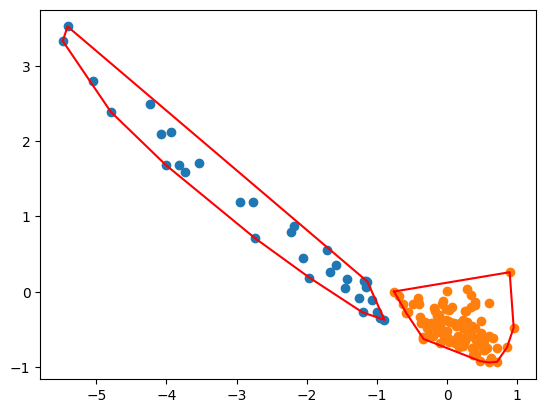

In [ ]:
thyroid_df = pd.read_csv("datasets/newthyroid.prepared.csv")
thyroid_df = thyroid_df.dropna()

thyroid_df_type = thyroid_df['Class']
thyroid_df.drop(columns=['Class'], inplace=True)

thyroid_df_reduced = PCA(n_components=2).fit_transform(thyroid_df)

class_2 = []
other_classes = []

index = 0
for color in thyroid_df_type:
    if color == 2:
        class_2.append(thyroid_df_reduced[index])
    elif color != 2 and color != 3:
        other_classes.append(thyroid_df_reduced[index])
    index+=1

class_2 = np.array(class_2)
other_classes = np.array(other_classes)

model_point_set_1, model_point_set_2, testing_point_set = DataTraining.separate_dataset(class_2, other_classes)

DataPlot.hull_plot(model_point_set_1, color="red")
DataPlot.hull_plot(model_point_set_2, color="red")

set_1_points = Tools.points_to_np_array(model_point_set_1)
set_2_points = Tools.points_to_np_array(model_point_set_2)

plt.scatter(set_1_points[:,0], set_1_points[:,1])
plt.scatter(set_2_points[:,0], set_2_points[:,1])

plt.show()

## Teste 7: ##

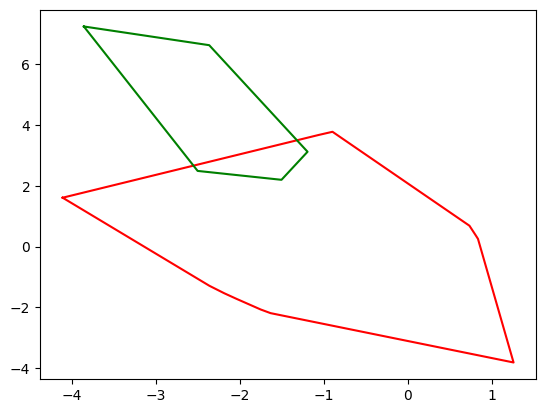

In [ ]:
ring_df = pd.read_csv('datasets/shuttle.csv')
ring_type = ring_df['Class']

ring_df.drop(columns=['Class'], inplace=True)
ring_reduced = PCA(n_components=2).fit_transform(ring_df)

ring_1_set = []
ring_2_set = []
index = 0
for ring in ring_type:
    if ring == 3:
        ring_1_set.append(Point(ring_reduced[index][0], ring_reduced[index][1]))
    elif ring == 6:
        ring_2_set.append(Point(ring_reduced[index][0], ring_reduced[index][1]))
    index+=1
    
DataPlot.hull_plot(ring_1_set, color="red")
DataPlot.hull_plot(ring_2_set, color="green")
plt.show()


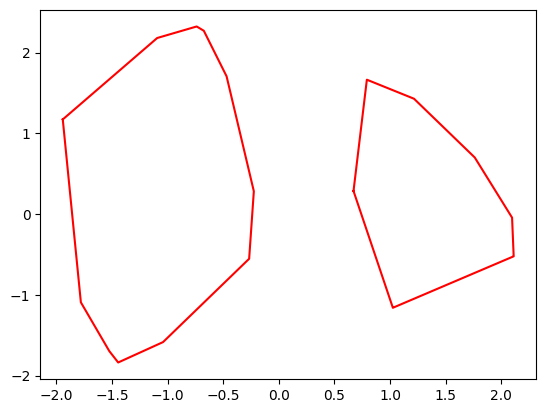

In [ ]:
phoneme_df = pd.read_csv('datasets/zoo.csv')
phoneme_type = phoneme_df['Type']

phoneme_df.drop(columns=['Type'], inplace=True)
phoneme_reduced = PCA(n_components=2).fit_transform(phoneme_df)

phoneme_set = []
non_phoneme_set = []
index = 0
for ring in phoneme_type:
    if ring == 1:
        phoneme_set.append(Point(phoneme_reduced[index][0], phoneme_reduced[index][1]))
    else:
        non_phoneme_set.append(Point(phoneme_reduced[index][0], phoneme_reduced[index][1]))
    index+=1
    
DataPlot.hull_plot(phoneme_set, color="red")
DataPlot.hull_plot(non_phoneme_set, color="red")
plt.show()

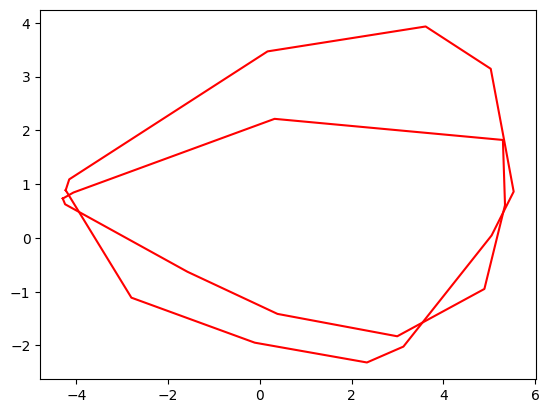

In [ ]:
phoneme_df = pd.read_csv('datasets/yeast.csv')
phoneme_type = phoneme_df['Class']

phoneme_df.drop(columns=['Class'], inplace=True)
phoneme_reduced = PCA(n_components=2).fit_transform(phoneme_df)

phoneme_set = []
non_phoneme_set = []
index = 0
for ring in phoneme_type:
    if ring == 'S':
        phoneme_set.append(Point(phoneme_reduced[index][0], phoneme_reduced[index][1]))
    elif ring == 'O':
        non_phoneme_set.append(Point(phoneme_reduced[index][0], phoneme_reduced[index][1]))
    index+=1
    
DataPlot.hull_plot(phoneme_set, color="red")
DataPlot.hull_plot(non_phoneme_set, color="red")
plt.show()